# Time Series Prediction with Van der Pol Oscillator Inspired Deep Learning ($VPINN$)

AUTHOR: Anurag Dutta (anuragdutta.research@gmail.com)

SUPERVISOR: Tanujit Chakraborty (tanujit.chakraborty@sorbonne.ae)

CREATED: 2023-03-12 16:27:40

## Gathering Dependencies

_Importing Required Libraries_

In [1]:
pip install hampel

You should consider upgrading via the 'C:\Users\Anurag Dutta\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [2]:
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import LSTM
import keras
import tensorflow as tf
from hampel import hampel
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Pretraining

_Van der Pol intermittancy_

The `van_der_pol_intermittency.dat` is generated from the Runge Kutta Method.

This feeds the model with the dynamics of the Van der Pol Oscillator

In [3]:
data = np.genfromtxt('datasets/van_der_pol_intermittency.dat')
training_set = pd.DataFrame(data).reset_index(drop=True)
training_set = training_set.iloc[:,1]

## Computing the Gradients

_Calculating the value of_ $\frac{dx}{dt}$, _and_ $\frac{d^2x}{dt^2}$

In [4]:
t_diff = 0.0416 # Hourly Data (1/24)
print(training_set.max())
gradient_t = (training_set.diff()/t_diff).iloc[1:]
print(gradient_t)
gradient_tt = (gradient_t.diff()/t_diff).iloc[1:]
print(gradient_tt)

1.0
1        -0.002404
2        -0.004904
3        -0.007503
4        -0.010205
5        -0.013011
            ...   
139867    0.111375
139868    0.111262
139869    0.111150
139870    0.111037
139871    0.110924
Name: 1, Length: 139871, dtype: float64
2        -0.060096
3        -0.062483
4        -0.064944
5        -0.067464
6        -0.070047
            ...   
139867   -0.002699
139868   -0.002710
139869   -0.002710
139870   -0.002710
139871   -0.002722
Name: 1, Length: 139870, dtype: float64


## Loading Datasets

_KYOTO DST_

In [5]:
data = pd.read_csv("datasets/dst.csv")
training_set = data.iloc[:, 1]
print(training_set)

0         -7
1        -10
2        -10
3         -6
4         -2
          ..
139867   -16
139868   -14
139869   -14
139870   -15
139871   -14
Name: dst, Length: 139872, dtype: int64


In [6]:
training_set = training_set.reset_index(drop=True)
gradient_t = gradient_t.reset_index(drop=True)
gradient_tt = gradient_tt.reset_index(drop=True)
print(gradient_t)
print(gradient_tt)

0        -0.002404
1        -0.004904
2        -0.007503
3        -0.010205
4        -0.013011
            ...   
139866    0.111375
139867    0.111262
139868    0.111150
139869    0.111037
139870    0.110924
Name: 1, Length: 139871, dtype: float64
0        -0.060096
1        -0.062483
2        -0.064944
3        -0.067464
4        -0.070047
            ...   
139865   -0.002699
139866   -0.002710
139867   -0.002710
139868   -0.002710
139869   -0.002722
Name: 1, Length: 139870, dtype: float64


In [7]:
print(gradient_t.shape)
print(training_set.shape[:-1])
df = pd.concat((training_set[:-1], gradient_t), axis=1)
gradient_tt.columns = ["grad_tt"]
df = pd.concat((df[:-1], gradient_tt), axis=1)
df.columns = ['y_t', 'grad_t', 'grad_tt']

(139871,)
()


## Preprocessing the Data into Supervised Learning

In [8]:
def Supervised(data, n_in=1):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    cols.append(df)
    names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    sup = pd.concat(cols, axis=1)
    sup.columns = names
    sup.dropna(inplace=True)
    return sup


data = Supervised(df.values, n_in=10)
data.drop(['var2(t-10)', 'var3(t-10)', 'var2(t-9)', 'var3(t-9)', 'var2(t-8)',
           'var3(t-8)', 'var2(t-7)', 'var3(t-7)', 'var2(t-6)', 'var3(t-6)',
           'var2(t-5)', 'var3(t-5)', 'var2(t-4)', 'var3(t-4)', 'var2(t-2)',
           'var3(t-2)', 'var2(t-1)', 'var3(t-1)', 'var2(t-3)', 'var3(t-3)'], axis=1, inplace=True)
print(data.head())
print(data.columns)
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)
print(data.shape)
y = data[:, -3:]
x = data[:, :-3]
print(x.shape)


    var1(t-10)  var1(t-9)  var1(t-8)  var1(t-7)  var1(t-6)  var1(t-5)  \
10        -7.0      -10.0      -10.0       -6.0       -2.0        3.0   
11       -10.0      -10.0       -6.0       -2.0        3.0        5.0   
12       -10.0       -6.0       -2.0        3.0        5.0        5.0   
13        -6.0       -2.0        3.0        5.0        5.0        3.0   
14        -2.0        3.0        5.0        5.0        3.0        1.0   

    var1(t-4)  var1(t-3)  var1(t-2)  var1(t-1)  var1(t)   var2(t)   var3(t)  
10        5.0        5.0        3.0        1.0      1.0 -0.032117 -0.085371  
11        5.0        3.0        1.0        1.0      2.0 -0.035669 -0.087613  
12        3.0        1.0        1.0        2.0      2.0 -0.039313 -0.089676  
13        1.0        1.0        2.0        2.0      3.0 -0.043044 -0.091479  
14        1.0        2.0        2.0        3.0      3.0 -0.046849 -0.092987  
Index(['var1(t-10)', 'var1(t-9)', 'var1(t-8)', 'var1(t-7)', 'var1(t-6)',
       'var1(t-5)', 

## Train and Test Split

In [9]:
train_size = int(len(y) * 0.8)
test_size = len(y) - train_size
dataX = np.array(x)
dataY = np.array(y)
trainX = np.array(x[0:train_size])
trainY = np.array(y[0:train_size])
testX = np.array(x[train_size:len(x)])
testY = np.array(y[train_size:len(y)])
trainX = trainX.reshape((trainX.shape[0], 1, trainX.shape[1]))
testX = testX.reshape((testX.shape[0], 1, testX.shape[1]))
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(111888, 1, 10) (111888, 3) (27972, 1, 10) (27972, 3)


## Model ($VPINN$)

In [10]:
model = Sequential()
model.add(LSTM(50, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(3))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(trainX, trainY, epochs=500, batch_size=64,
                    validation_data=(testX, testY), verbose=2, shuffle=False)

Epoch 1/500
1749/1749 - 16s - loss: 0.0627 - val_loss: 0.0533 - 16s/epoch - 9ms/step
Epoch 2/500
1749/1749 - 9s - loss: 0.0564 - val_loss: 0.0532 - 9s/epoch - 5ms/step
Epoch 3/500
1749/1749 - 9s - loss: 0.0557 - val_loss: 0.0532 - 9s/epoch - 5ms/step
Epoch 4/500
1749/1749 - 10s - loss: 0.0553 - val_loss: 0.0532 - 10s/epoch - 6ms/step
Epoch 5/500
1749/1749 - 10s - loss: 0.0550 - val_loss: 0.0532 - 10s/epoch - 6ms/step
Epoch 6/500
1749/1749 - 11s - loss: 0.0548 - val_loss: 0.0532 - 11s/epoch - 7ms/step
Epoch 7/500
1749/1749 - 10s - loss: 0.0546 - val_loss: 0.0532 - 10s/epoch - 6ms/step
Epoch 8/500
1749/1749 - 11s - loss: 0.0545 - val_loss: 0.0532 - 11s/epoch - 6ms/step
Epoch 9/500
1749/1749 - 13s - loss: 0.0544 - val_loss: 0.0532 - 13s/epoch - 7ms/step
Epoch 10/500
1749/1749 - 12s - loss: 0.0543 - val_loss: 0.0532 - 12s/epoch - 7ms/step
Epoch 11/500
1749/1749 - 12s - loss: 0.0543 - val_loss: 0.0532 - 12s/epoch - 7ms/step
Epoch 12/500
1749/1749 - 10s - loss: 0.0542 - val_loss: 0.0534 - 10

## Metrics ($VPINN$)

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
yhat = model.predict(testX)
print(yhat.shape)
testX = testX.reshape((testX.shape[0], testX.shape[2]))
print(testX.shape)
inv_yhat = np.concatenate((testX, yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat1 = inv_yhat[:, -3:]
inv_yhat = inv_yhat[:, -3]
inv_y = np.concatenate((testX, testY), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y1 = inv_y[:, -3:]
inv_y = inv_y[:, -3]
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)

875/875 [==============================] - 5s 3ms/step
(27972, 3)
(27972, 10)
Test RMSE: 3.335
Test MAE: 2.533


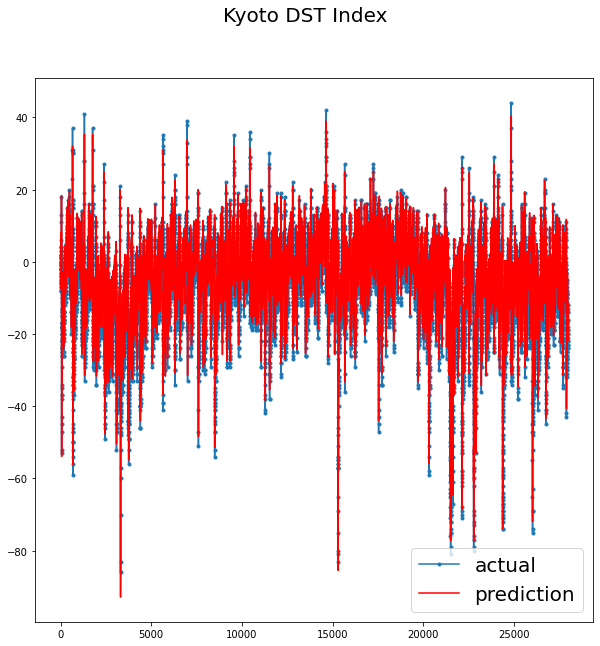

In [12]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 10] # for square canvas
plt.plot(inv_y, marker='.', label="actual")
plt.plot(inv_yhat, 'r', label="prediction")
plt.suptitle('Kyoto DST Index', fontsize=20)
plt.legend(fontsize=20)
plt.show()